In [1]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn,an estimator for classification and a widely used machine learning library in Python
# It is a Python object that implements the methods fit(X, y) and predict(T).
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
# Cross validation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, cross_val_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
# Confusion Matrix
from sklearn.metrics import confusion_matrix
# classification report
from sklearn.metrics import classification_report
# scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
wines = pd.read_csv("Data\wines.csv")
print(wines.shape)
wines.head()

(6497, 15)


,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label
0,0,7.0,0.25,0.45,2.3,0.045,40.0,118.0,0.99064,3.16,0.48,11.9,7,white,medium
1,1,7.6,0.14,0.74,1.6,0.040,27.0,103.0,0.99160,3.07,0.40,10.8,7,white,medium
2,2,6.2,0.15,0.27,11.0,0.035,46.0,116.0,0.99602,3.12,0.38,9.1,6,white,medium
3,3,6.7,0.16,0.32,12.5,0.035,18.0,156.0,0.99666,2.88,0.36,9.0,6,white,medium
4,4,6.8,0.27,0.22,17.8,0.034,16.0,116.0,0.99890,3.07,0.53,9.2,5,white,low


In [33]:
wines.drop(columns=["Unnamed: 0"],inplace=True)

In [34]:
# reshuffling the records in the DF is important to make sure the data taken into account by the model will be surely a mix of red and white wines

wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label
0,6.0,0.200,0.32,3.0,0.031,26.0,118.0,0.99134,3.38,0.68,11.2,7,white,medium
1,9.2,0.430,0.49,2.4,0.086,23.0,116.0,0.99760,3.23,0.64,9.5,5,red,low
2,6.3,0.270,0.18,7.7,0.048,45.0,186.0,0.99620,3.23,0.47,9.0,5,white,low
3,8.6,0.485,0.29,4.1,0.026,19.0,101.0,0.99180,3.01,0.38,12.4,5,white,low
4,7.7,0.270,0.34,1.8,0.028,26.0,168.0,0.99110,2.99,0.48,12.1,7,white,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,8.3,0.280,0.48,2.1,0.093,6.0,12.0,0.99408,3.26,0.62,12.4,7,red,medium
6493,8.6,0.360,0.26,11.1,0.030,43.5,171.0,0.99480,3.03,0.49,12.0,5,white,low
6494,6.8,0.660,0.07,1.6,0.070,16.0,61.0,0.99572,3.29,0.60,9.3,5,red,low
6495,7.7,0.320,0.62,10.6,0.036,56.0,153.0,0.99780,3.13,0.44,8.9,6,white,medium


In [35]:
#
#
# Logistic Regression on quality_label
#
#

In [36]:
wines = wines.astype({"quality_label":'category'})
wines.dtypes

fixed acidity            float64
volatile acidity         float64
citric acid              float64
residual sugar           float64
chlorides                float64
free sulfur dioxide      float64
total sulfur dioxide     float64
density                  float64
pH                       float64
sulphates                float64
alcohol                  float64
quality                    int64
wine_type                 object
quality_label           category
dtype: object

In [37]:
# "Quality_label" category is directly related to the "Quality" feature. Here I will check through the .corr() function the correlation of all columns in the DF with the feature "Quality".

wines.corr()['quality'].sort_values(ascending = False)

quality                 1.000000
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64

In [38]:
# Only the meaningful variables should be included.
# Outcome of the above correlation is that "residual sugar","pH" and "sulphates" have less impact on the quality of wine. 
# I will proceed with the dropping the 3 columns.

wines.drop(columns = ["residual sugar","pH", "sulphates"], inplace= True)

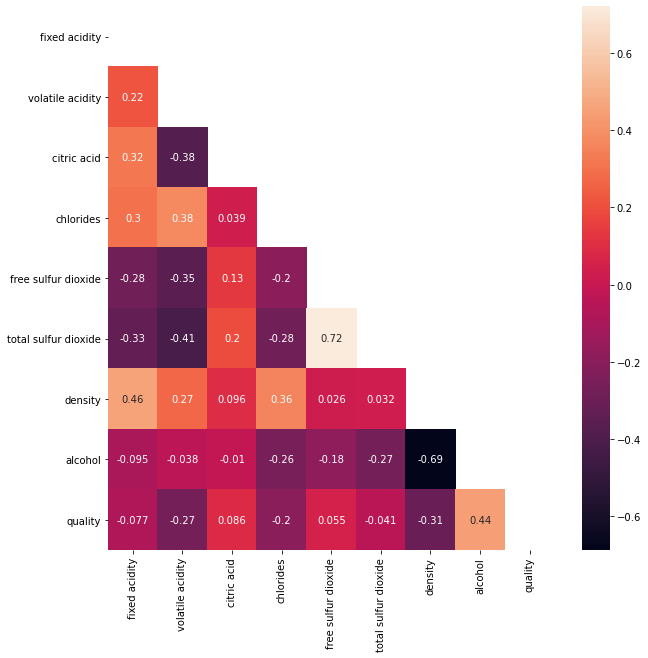

In [41]:
# I will run one more check with a correlation heatmap.
# Here I notice that alcohol and density have a high correlation so it is not necessary to keep both of them. I will keep just the one with an higher correlation with quality. 

plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(wines.corr(), dtype=bool))
plot = sns.heatmap(wines.corr(), annot= True, mask=mask);

In [42]:
# Drop the "Density" column and quality which will be my discrete variable and the desired target.
# The remaining columns will be the X data that needs to be transformed in binary data (1,0)

X = wines.drop(columns = ['quality', 'quality_label' , 'density'])
y = wines['quality_label']
X = pd.get_dummies(X)

In [44]:
# scaling the features
scaler = MinMaxScaler()
print(scaler.fit(X))
# Scale the test set
X = scaler.transform(X)

MinMaxScaler()


In [45]:
# data separated in a train set and a prediction set(test)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

In [46]:
# since I set the test size on 0.2 a fifth of all data should be part of it
X_test.shape

(1300, 9)

In [47]:
# now train the model on my training dataset and labels using logistic regression

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
lr.get_params();

In [48]:
# Predicting the test set results

lr.predict(X_test)

array(['low', 'medium', 'low', ..., 'medium', 'medium', 'low'],
      dtype=object)

In [49]:
# Calculating the accuracy
# y_test = predicted values
# Accuracy of logistic regression classifier on test set: 0.69

score = lr.score(X_test, y_test)
print('Test Accuracy Score', score)

Test Accuracy Score 0.6946153846153846


In [291]:
# Confusion Matrix - table allowing visualization of the performance of an algorithm
# Column Actual class
# rows predicted class
# the result is telling us that we have 0 + 244 + 654 correct predictions and 4 + 42 + 1 + 217 + 1 + 137 incorrect predictions 

confusion_matrix(y_test, lr.predict(X_test))

array([[  0,   4,  42],
       [  1, 244, 217],
       [  1, 137, 654]], dtype=int64)

In [50]:
# print classification report

# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0. The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.
# The support is the number of occurrences of each class in y_test.

predictions= lr.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        34
         low       0.61      0.53      0.56       453
      medium       0.73      0.82      0.77       813

    accuracy                           0.69      1300
   macro avg       0.45      0.45      0.45      1300
weighted avg       0.67      0.69      0.68      1300



In [ ]:
#
#
#Cross validation
#
#

In [51]:
predicted = cross_val_predict(lr, X, y, cv=12)
print(accuracy_score(y, predicted))
print (metrics.classification_report(y, predicted))
predicted

0.7021702324149608
              precision    recall  f1-score   support

        high       0.00      0.00      0.00       198
         low       0.65      0.57      0.61      2384
      medium       0.73      0.82      0.77      3915

    accuracy                           0.70      6497
   macro avg       0.46      0.46      0.46      6497
weighted avg       0.68      0.70      0.69      6497



array(['medium', 'low', 'low', ..., 'low', 'low', 'low'], dtype=object)

In [52]:
# get the scores for 10 splits
scores= cross_val_score(lr, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.68269231 0.72884615 0.68269231 0.71923077 0.67307692 0.7
 0.71538462 0.70712909 0.73410405 0.70712909]


In [53]:
# Check the range of of scores with min max and mean
scores= pd.Series(scores)
scores

0    0.682692
1    0.728846
2    0.682692
3    0.719231
4    0.673077
5    0.700000
6    0.715385
7    0.707129
8    0.734104
9    0.707129
dtype: float64

In [54]:
print(scores.min(), score.max(), scores.mean())

0.6730769230769231 0.6946153846153846 0.7050285311990515


In [56]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5)
k_fold.split(X);

In [346]:
X.to_numpy()

array([[ 7.  ,  0.25,  0.45, ..., 11.9 ,  0.  ,  1.  ],
       [ 7.6 ,  0.14,  0.74, ..., 10.8 ,  0.  ,  1.  ],
       [ 6.2 ,  0.15,  0.27, ...,  9.1 ,  0.  ,  1.  ],
       ...,
       [13.4 ,  0.27,  0.62, ...,  9.7 ,  1.  ,  0.  ],
       [ 8.9 ,  0.4 ,  0.51, ..., 13.4 ,  1.  ,  0.  ],
       [ 8.1 ,  0.27,  0.35, ..., 10.4 ,  0.  ,  1.  ]])

In [57]:
y.to_numpy()

array(['medium', 'low', 'low', ..., 'low', 'medium', 'low'], dtype=object)

In [58]:
# ultimo check su train score e test score
# qua devo prestare attenzione alal forma dei dati che sto utilizzando: (codici precedetni prima)
# for train, test in k_fold.split(X): -> X e' un dataframe mentre qui sto gaurdando agli indici di un Array pertanto dovrò modificare X a array
# la stessa cosa con y che è una serie

for train, test in k_fold.split(X.to_numpy()):
    lr.fit(X.to_numpy()[train], y.to_numpy()[train])
    test_score = lr.score(X.to_numpy()[test], y.to_numpy()[test])
    train_score = lr.score(X.to_numpy()[train], y.to_numpy()[train])
    print('test_score',test_score)
    print('train_score',train_score)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'